Evaluation pour le poste data scientist Inria-AP-HP

In [182]:
#Importation des librairies néccesaire et connexion à la base de données SQLITE3 data.db

import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline

engine = create_engine('sqlite:///C:\\Users\\Djonga\\Desktop\\DU BIG DATA\\Background\\Test\\data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

Pour vérifier que la connexion à la base de données a été faite correctement, on va afficher les cinq premières lignes des tables patients et de tests PCR.
Nous affichons aussi la dimension (nombre des lignes et colonnes)

In [183]:
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None


In [184]:
df_patient.shape

(20000, 12)

In [185]:
df_pcr.head()

,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative


In [186]:
df_pcr.shape

(8800, 2)

Pour réaliser le diagnostic sur la qualité de données, on compte le nombre des valeurs manquantes, uniques et doublons  à l'aide des tris à plats sur les colonnes qualitatives ou en calculant la moyenne, le maximum et le minimum pour les colonnes quantitaves. 

Concretèment pour les tables de la base data.db, les dimensions et facteurs de la qualités de données suivantes peuvent être examinées: 

1. La complétude: les facteurs données manques et doublons. Comme les doublons sur la colonne patient_id dans la table test pour identifier les patiens qui ont été testés plusieurs fois. Si nous avons la colonne pcr manquante, alors on manque le resultat du test pour un patient donné;

2. Exactitude: les facteurs format et précision. La variable pcr dans la table est codé en “Negative” et “N” pour le test dont le resultat est negatif. Il y a aussi la variable de type date “date_of_birth” que pandas lit comme réel;

3. Confidentialité: La jointure entre ces deux tables viole la RGPD. Les patients sont identifiables avec leur résultat médical respectif, ce qui est contraire au principe de la protection de données à caractères personnelles. Un dossier médical est privé et confidentiel, il faut penser à l'anonymisation ou à la pseudonymisation.

In [187]:
#Fonction to delete duplicated from patient table

def detect_duplicates(myData):
    
    # We found duplicates based on the column patient_id 
    #The pandas's function duplicated return  a boolean series with True if the row is a duplicated. 
    
    percentDuplicated = round(myData[myData.duplicated(['patient_id'])].shape[0]/myData.shape[0],4) * 100
    print("Percent of duplicated rows based on the column patient_id:", percentDuplicated ,"%")
    
    #Delete duplicated rows
    duplicate_patient = myData[myData.duplicated(['patient_id']) == False]
  
    return duplicate_patient

In [188]:
noDuplicatePatient =  detect_duplicates(df_patient)

Percent of duplicated rows based on the column patient_id: 1.01 %


Nous allons faire l'analyse exploiratoire sur les 8800 patients atteints du Covid-19, donc on commence par faire une jointure à gauche pour ajouter dans la table test pcr (df_pcr) les données des patients se trouvant dans la table des patients (df_patient).

In [189]:
df_pcr = df_pcr.merge(noDuplicatePatient, on='patient_id', how='left')
df_pcr.head()

,patient_id,pcr,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,653091,N,daniel,campbell,58.0,sid barnes crescent,north ward,4514,nsw,19730426.0,NaN,08 38772117,None
1,347667,Negative,sebastian,mchenry,12.0,mundawari circuit,swan view,4551,wa,19900316.0,28.0,08 61083524,ocean star villas
2,708481,Positive,sarah,rellos,20.0,torres street,bribie island,3199,sa,19430317.0,NaN,02 73197286,None
3,148825,Negative,chloe,brammy,238.0,fitchett street,carnegie,3280,qld,19540528.0,19.0,02 48826642,None
4,150081,Negative,charlie,None,6.0,clark close,south melbourne,2602,qld,19750331.0,35.0,03 24096098,talawa


In [190]:
df_pcr.shape

(8800, 13)

Le tris à plat sur la colonne pcr montre un problème de formatage ou saisie de données. Nous avons 'N' et 'Negative', 'P' et 'Positive'.

In [191]:
df_pcr['pcr'].value_counts(dropna = False)

N           3482
Negative    3134
Positive    1283
P            901
Name: pcr, dtype: int64

Correction de la colonne 'pcr'. On recode "N" en "negative" et "P" en positive.

In [193]:
clean_pcr = {"pcr": {"N": "Negative", "P": "Positive"}}
df_pcr.replace(clean_pcr, inplace = True)
df_pcr['pcr'].value_counts()

Negative    6616
Positive    2184
Name: pcr, dtype: int64

Pour faire une analyse exploratoire sur l'âge des personnes atteintes de la covid-19, on étudie d'abord la distribution de la variable 'age' avant de procéder au recodage en catégorie.

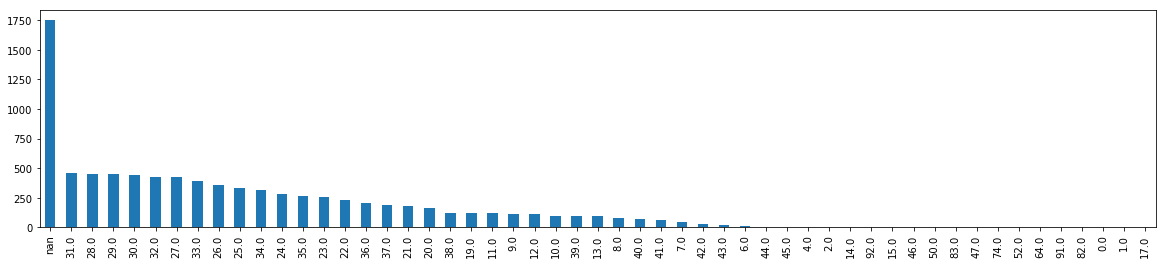

In [194]:
distr = df_pcr['age'].value_counts(dropna = False, sort = True)
plt.rcParams["figure.figsize"] = (20,4)
distr.plot(kind='bar')
plt.show()


In [195]:
distr

NaN      1749
 31.0     458
 28.0     450
 29.0     447
 30.0     446
 32.0     429
 27.0     424
 33.0     390
 26.0     359
 25.0     335
 34.0     313
 24.0     284
 35.0     266
 23.0     259
 22.0     229
 36.0     206
 37.0     189
 21.0     181
 20.0     161
 38.0     126
 19.0     121
 11.0     119
 9.0      111
 12.0     110
 10.0     100
 39.0      97
 13.0      94
 8.0       76
 40.0      69
 41.0      59
 7.0       49
 42.0      26
 43.0      19
 6.0       10
 44.0       7
 45.0       6
 4.0        5
 2.0        3
 14.0       2
 92.0       2
 15.0       2
 46.0       1
 50.0       1
 83.0       1
 47.0       1
 74.0       1
 52.0       1
 64.0       1
 91.0       1
 82.0       1
 0.0        1
 1.0        1
 17.0       1
Name: age, dtype: int64

Pour connaitre la tranche d'age la plus testée à la covid-19, on commence par faire le codage en tranche d'âge pour la variable 'age'.
On constate une grande présence des données manquantes. Il ya aussi la présence des nourrisons qui ont été testés à la Covid-19 et les jeunes agés jusqu'à 30 sont la tranche la plus testée.


In [196]:
bins = [0, 9, 20, 30, 40, np.inf]
names = ['10-', '10-20', '21-30', '31-40', '40+']
df_pcr['catAge'] = pd.cut(df_pcr['age'], bins, labels=names)
df_pcr['catAge'].value_counts(dropna = False, sort = True)

21-30    3414
31-40    2543
NaN      1750
10-20     710
10-       255
40+       128
Name: catAge, dtype: int64

Répartition de cas des covid-19 par tranche d'age et localisation géographique.

Il est inquiétant de remarquer le nombre des cas positifs parmis les moins de 10 ans . Les jeunes entre 21 ans et 30 sont aussi pas mal atteints à la covid-19. Il y a eu très peu des seniors testés, d'où ce petit chiffre des positifs au covid-19.


In [197]:
#This function take a column's name, counts the number of positive, negative and the graph for vizualization
def crossGraph(col):
    
    print("Répartiton des cas des Covid-19 par: ", col)
    #cross analysis
    tab = pd.crosstab(df_pcr[col], df_pcr['pcr'], dropna = True)
    print(tab)
    #printing the graph
    tab.plot.bar(stacked=False)
    plt.show()

Répartiton des cas des Covid-19 par:  catAge
pcr     Negative  Positive
catAge                    
10-          186        69
10-20        529       181
21-30       2573       841
31-40       1907       636
40+          101        27


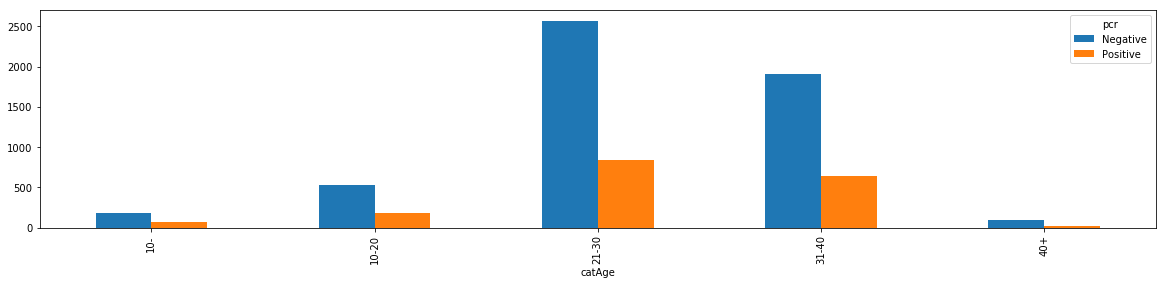

Répartiton des cas des Covid-19 par:  state
pcr    Negative  Positive
state                    
act          88        30
ai            1         0
fsw           1         0
gic           1         0
ic            0         1
naw           1         0
ndw           1         0
nfsw          1         0
nfw           0         1
nlw           1         0
ns            2         0
nsa           1         0
nsc           0         1
nsd           1         1
nse           2         0
nsg           1         0
nsn           1         0
nsq           1         1
nss           1         4
nsw        1967       634
nswb          0         1
nswf          1         0
nswt          0         1
nsy           1         0
nt           46         5
nu            2         0
nvq           0         1
nwx           0         1
nxw           0         1
qdd           1         0
...         ...       ...
qud           1         0
qxlj          1         0
s             0         1
sa          472     

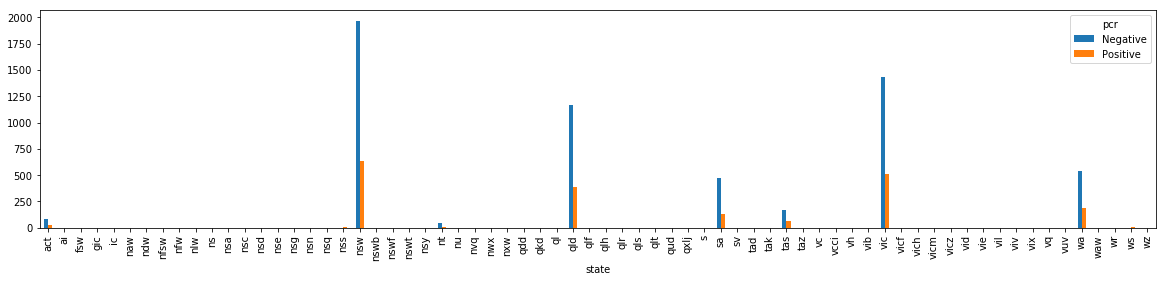

In [200]:
colNames = ['catAge', 'state']
for elt in colNames:
    crossGraph(elt)